# Learn a logo detector using DeTr
## Hands-on Tutorial KDD2020
* **By** Dr. James G. Shanahan
* **Email:** James.Shanahan __AT__ gmail.com

The goal of this Google Colab notebook is to fine-tune Facebook's DETR (DEtection TRansformer) for the task of recognizing logos (company/product). The DETR architecture replaces the full complex hand-crafted object detection pipeline with a Transformer, and matches Faster R-CNN with a ResNet-50, to 42 mAP on COCO using half the computation power (FLOPs) and the same number of parameters. Inference can be accomplishe in 50 lines of PyTorch. For more details on the DeTr system see the original paper [here](https://arxiv.org/abs/2005.12872). 

# The Logos Dataset

The dataset we use here to introduce the key concepts behind training and deploying a RetinaNet model is the ROMYNY Logo 2016 [Frank Fotso, 2017. Application of py_faster_rcnn in logo detection task: ZF & VGG16]( https://github.com/franckfotso/faster_rcnn_logo/blob/master/README.md), a collection of twenty popular
logo classes, such as Adidas, Facebook, BWM, Coca Cola, and others. A montage of these logos
can be seen below.

In the logos dataset there are 20 classes of logos, with a total of `935` images in the dataset, with anywhere between 19-159 images per class,
making the dataset imbalanced, but representative of what we may encounter in the real-world. 
Overall, there  are `748 training images` in the 'training' set and 187 test images. This translates into  `1393 object regions` in the training bbox+class set.  See next for a sample of some images and their logo annotations.

# Download the Logos Dataset and cleanup annotations file


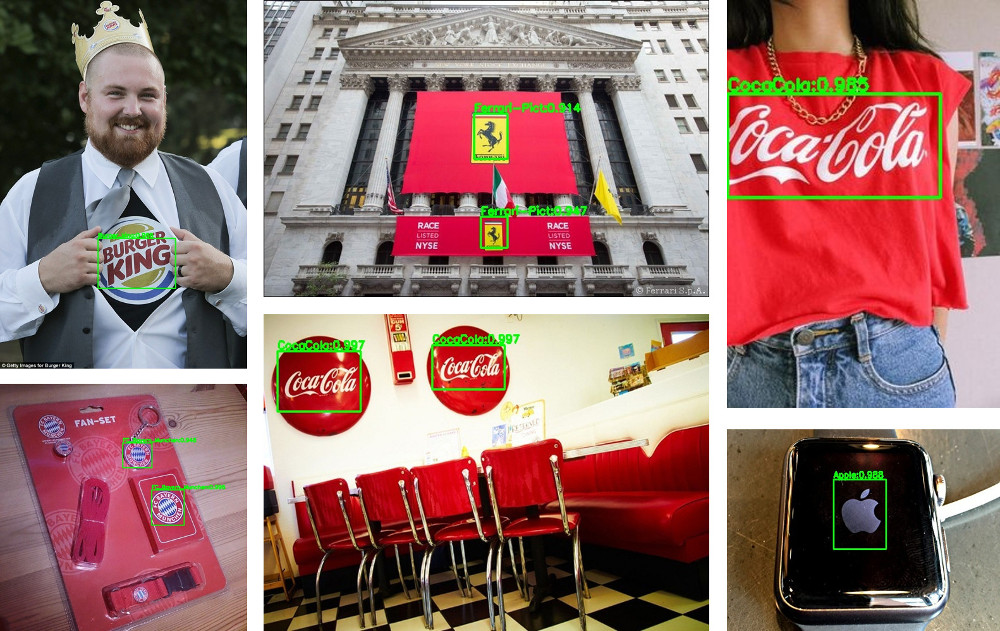

In [ ]:
!wget -q https://www.dropbox.com/s/tik2mry1i991596/lots_of_logos.jpg -O lots_of_logos.jpg
%matplotlib inline
from IPython.display import Image
Image('./lots_of_logos.jpg', width=600)# height=300)

The following table includes the full breakdown on number of images per logo class for the logos dataset:

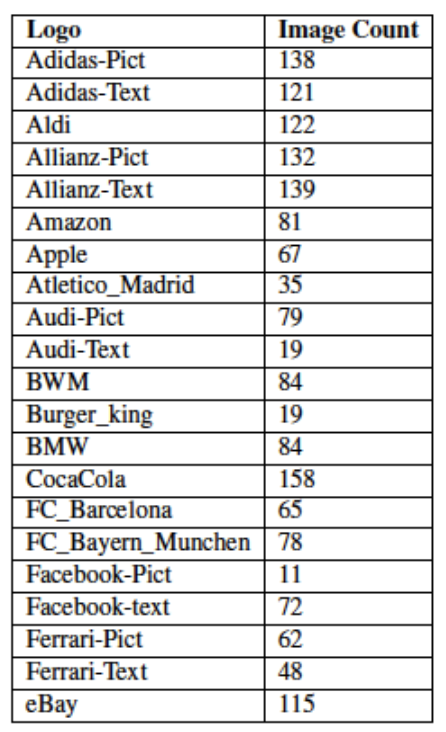

## Download Logos dataset

In [51]:
!wget  https://www.dropbox.com/sh/6eqjfc6kplextab/AADBlZnYj-yMLWWuK6Z8RF8ta?dl=0 -O logos.zip



--2020-08-26 01:42:53--  https://www.dropbox.com/sh/6eqjfc6kplextab/AADBlZnYj-yMLWWuK6Z8RF8ta?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/6eqjfc6kplextab/AADBlZnYj-yMLWWuK6Z8RF8ta [following]
--2020-08-26 01:42:53--  https://www.dropbox.com/sh/raw/6eqjfc6kplextab/AADBlZnYj-yMLWWuK6Z8RF8ta
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca62dc96070d9b70654ac0178ad.dl.dropboxusercontent.com/zip_download_get/AhiH-EsO9ZPzv4kd8F81sLGuz7sYDItMDtKWE7YXZ9U6RgFTDG94pmVrIskAnLtId5CzX8EYqUzwE-Usf-fX2LtWZI_Gv1z5ThYDtDtvI4fwiA [following]
--2020-08-26 01:42:55--  https://uca62dc96070d9b70654ac0178ad.dl.dropboxusercontent.com/zip_download_get/AhiH-EsO9ZPzv4kd8F81sLGuz7sYDItMDtKWE7YXZ9U6RgFTDG94pmVrIskAnLtId5CzX8EYqUzwE-Usf-fX

In [57]:
!unzip logos.zip -d logos > /dev/null 2>&1

In [58]:
!ls -l

total 279056
drwxr-xr-x 5 root root      4096 Aug 26 01:38 logos
-rw-r--r-- 1 root root 285493367 Aug 26 01:44 logos.zip
-rw-r--r-- 1 root root    244313 Aug 26 01:41 lots_of_logos.jpg
drwxr-xr-x 1 root root      4096 Aug 24 16:35 sample_data
drwxr-xr-x 4 root root      4096 Aug 26 01:38 voc2coco


In [59]:
!ls -l logos/images|head

total 142628
-rwxr--r-- 1 root root   67994 Dec 25  2018 001637.jpg
-rwxr--r-- 1 root root   51977 Dec 25  2018 001813.jpg
-rwxr--r-- 1 root root   57598 Dec 25  2018 004221.jpg
-rwxr--r-- 1 root root   71672 Dec 25  2018 007622.jpg
-rwxr--r-- 1 root root   89977 Dec 25  2018 008634.jpg
-rwxr--r-- 1 root root   47399 Dec 25  2018 008696.jpg
-rwxr--r-- 1 root root   61107 Dec 25  2018 008906.jpg
-rwxr--r-- 1 root root  406670 Dec 25  2018 009225.jpg
-rwxr--r-- 1 root root  110090 Dec 25  2018 009944.jpg


## Clean up annotations to make compliant with  PASCAL VOC format

In [60]:
import os
import glob

import numpy as np

from bs4 import BeautifulSoup

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import cv2
from PIL import Image
import matplotlib.pyplot as plt

Get all the images and annotations list

In [61]:
f_images = sorted(glob.glob("./logos/images/**/*.*", recursive=True))
f_annots = sorted(glob.glob("./logos/annotations/**/*.*", recursive=True)) # all annotation filenames

## Fix annotation filename field

Replace `im_fn` with the real image filename.  Initially all the annotations files contain `im_fn` in the field `<filename>`. In fact, they should contain the real filename. We can  parse it from the annotation filename and replace.

In [62]:
def fix_namings(file):
    with open(file) as f:
        d = f.read()

    d = d.replace("<filename>im_fn</filename>", 
                  f"<filename>{os.path.splitext(os.path.basename(file))[0] + '.jpg'}</filename>")

    with open(file, "w") as f:
        f.write(d)

In [63]:
_ = Parallel(n_jobs=8)(delayed(fix_namings)(file) for file in tqdm(f_annots))

## Delete duplicated annotations

Some of the annotations are duplicated. One should delete them for better performance and more fair evaluation.

In [64]:
def delete_duplicates(file):

    with open(file) as f:
        soup = BeautifulSoup(f.read())

    objects = set()
    for obj in soup.find_all("object"):
        xmin = int(obj.find("xmin").text)
        xmax = int(obj.find("xmax").text)
        ymin = int(obj.find("ymin").text)
        ymax = int(obj.find("ymax").text)
        name = obj.find("name").text
        current_obj = (name, xmin, xmax, ymin, ymax)
        if current_obj not in objects:
            objects.add(current_obj)
        else:
            obj.decompose()

    with open(file, "w") as f:
        f.write(str(soup.find("body").contents[0]))

In [65]:
_ = Parallel(n_jobs=8)(delayed(delete_duplicates)(file) for file in tqdm(f_annots))

# Get list of classes

To enumerate all the classes we first need to get the full list of them.

In [66]:
def get_classes(file):
    with open(file) as f:
        d = f.read()
    soup = BeautifulSoup(d)
    all_classes = set()
    for obj in soup.find_all("object"):
        all_classes.add(obj.find("name").text)
    return list(all_classes)

In [67]:
res = Parallel(n_jobs=16)(delayed(get_classes)(file) for file in tqdm(f_annots))

Class counts

In [68]:
import pandas as pd
pd.DataFrame(zip(*np.unique([item for sublist in res for item in sublist], return_counts=True)))

,0,1
0,Adidas-Pict,60
1,Adidas-Text,58
2,Aldi,74
3,Allianz-Pict,73
4,Allianz-Text,74
5,Amazon,57
6,Apple,63
7,Atletico_Madrid,31
8,Audi-Pict,53
9,Audi-Text,17


Write classes to the file.

In [69]:
with open("./logos/classes.txt", "w") as f:
    for c in sorted(list(set(np.concatenate(res)))):
        print(f"{c}")
        f.write(c + "\n")

Adidas-Pict
Adidas-Text
Aldi
Allianz-Pict
Allianz-Text
Amazon
Apple
Atletico_Madrid
Audi-Pict
Audi-Text
BMW
Burger_king
CocaCola
FC_Barcelona
FC_Bayern_Munchen
Facebook-Pict
Facebook-Text
Ferrari-Pict
Ferrari-Text
eBay


# Load one sample image and annotations  and display

Read annotations for one data example

In [70]:
f_annots[:3] # all annotation filenames

['./logos/annotations/001637.xml',
 './logos/annotations/001813.xml',
 './logos/annotations/004221.xml']

In [ ]:
!cat ./logos/annotations/001637.xml

<annotation>
<folder>VOC2007</folder>
<filename>001637.jpg</filename>
<source>
<database>ROMYNY Database</database>
<annotation>ROMYNY Annotation</annotation>
<image>Unspecified</image>
</source>
<owner>
<name>Unspecified</name>
</owner>
<size>
<width>250</width>
<height>333</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>Ferrari-Text</name>
<pose>Unspecified</pose>
<truncated>1</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>72</xmin>
<ymin>232</ymin>
<xmax>131</xmax>
<ymax>275</ymax>
</bndbox>
</object>
<object>
<name>Ferrari-Text</name>
<pose>Unspecified</pose>
<truncated>1</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>140</xmin>
<ymin>130</ymin>
<xmax>195</xmax>
<ymax>163</ymax>
</bndbox>
</object>
<object>
<name>Ferrari-Text</name>
<pose>Unspecified</pose>
<truncated>1</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>71</xmin>
<ymin>103</ymin>
<xmax>123</xmax>
<ymax>134</ymax>
</bndbox>
</object>
<object>
<name>Ferrari-Pict</name>
<pose>Unspe

In [71]:
# Look at the first image's annotation
with open(f_annots[0]) as f:
    d = f.read()
soup = BeautifulSoup(d)

Read an image

In [72]:
im = cv2.imread(f_images[0]) #load image

Draw bboxes

In [73]:
for obj in soup.find_all("object"):
    xmin = int(obj.find("xmin").text)
    xmax = int(obj.find("xmax").text)
    ymin = int(obj.find("ymin").text)
    ymax = int(obj.find("ymax").text)
    name = obj.find("name").text
    im = cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (255, 0, 0))

Show results

In [74]:
print(im.shape) #(333, 250, 3)
print(type(im)) # numpy 
# OpenCV image format supports the numpy array interface. A helper function can be made to support either grayscale or color images. 
# This means the BGR -> RGB conversion can be conveniently done with a numpy slice, not a full copy of image data.
mm= np.arange(18).reshape(3,2,3)
print(mm)
print(mm[:, :, ::-1]) # BGR -> RGB conversion
print(mm[..., ::-1])  # same as previous line keep all the other indices the same apart from the last index

(333, 250, 3)
<class 'numpy.ndarray'>
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
[[[ 2  1  0]
  [ 5  4  3]]

 [[ 8  7  6]
  [11 10  9]]

 [[14 13 12]
  [17 16 15]]]
[[[ 2  1  0]
  [ 5  4  3]]

 [[ 8  7  6]
  [11 10  9]]

 [[14 13 12]
  [17 16 15]]]


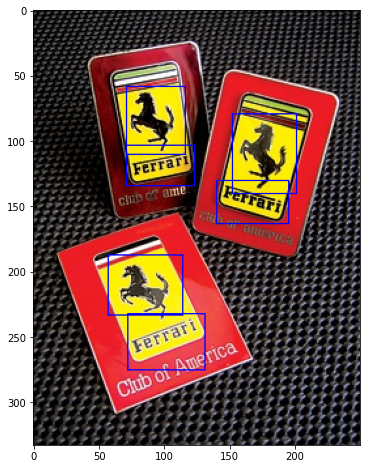

In [75]:
im.shape

plt.figure(figsize=(20, 8))
plt.imshow(im[..., ::-1])  # BGR -> RGB conversion of the last index 

# Transform Pascal XML format to COCO JSON format

Let's finally convert to COCO format to train the network.

To do so we will use `voc2coco` util from github.

In [76]:
!git clone https://github.com/yukkyo/voc2coco.git

fatal: destination path 'voc2coco' already exists and is not an empty directory.


In [77]:
!cd voc2coco && \
 python voc2coco.py \
            --ann_dir ../logos/annotations \
            --ann_ids ../logos/test.txt \
            --labels ../logos/classes.txt \
            --output ../logos/valid_coco.json \
            --ext xml && \
 python voc2coco.py \
            --ann_dir ../logos/annotations \
            --ann_ids ../logos/train.txt \
            --labels ../logos/classes.txt \
            --output ../logos/train_coco.json \
            --ext xml

Start converting !
100% 187/187 [00:00<00:00, 13314.57it/s]
Start converting !
100% 748/748 [00:00<00:00, 17928.06it/s]


In [84]:
!head -15 logos/train_coco.json

{"images": [{"file_name": "452893.jpg", "height": 1080, "width": 1920, "id": 452893}, {"file_name": "409261.jpg", "height": 672, "width": 1024, "id": 409261}, {"file_name": "494313.jpg", "height": 1280, "width": 960, "id": 494313}, {"file_name": "622941.jpg", "height": 385, "width": 385, "id": 622941}, {"file_name": "981220.jpg", "height": 250, "width": 288, "id": 981220}, {"file_name": "847883.jpg", "height": 449, "width": 600, "id": 847883}, {"file_name": "639671.jpg", "height": 493, "width": 740, "id": 639671}, {"file_name": "372355.jpg", "height": 376, "width": 645, "id": 372355}, {"file_name": "694084.jpg", "height": 746, "width": 1024, "id": 694084}, {"file_name": "736404.jpg", "height": 560, "width": 1000, "id": 736404}, {"file_name": "575450.jpg", "height": 533, "width": 800, "id": 575450}, {"file_name": "495542.jpg", "height": 438, "width": 584, "id": 495542}, {"file_name": "207861.jpg", "height": 298, "width": 377, "id": 207861}, {"file_name": "588116.jpg", "height": 426, "wi

JSON Structure
```python
{"images": [{"file_name": "452893.jpg", "height": 1080, "width": 1920, "id": 452893}, {"file_name": "409261.jpg",....}]

'type': [...], 
'annotations': [...], 
'categories':[.....]
```


In [97]:
import json
train_annotations_json = json.loads(open("logos/train_coco.json", "r").read()) 
print(train_annotations_json.keys())


print(train_annotations_json["images"][:3])
print(train_annotations_json["type"][:3])
print(train_annotations_json["annotations"][:3])
print(train_annotations_json["categories"][:3])


dict_keys(['images', 'type', 'annotations', 'categories'])
[{'file_name': '452893.jpg', 'height': 1080, 'width': 1920, 'id': 452893}, {'file_name': '409261.jpg', 'height': 672, 'width': 1024, 'id': 409261}, {'file_name': '494313.jpg', 'height': 1280, 'width': 960, 'id': 494313}]
ins
[{'area': 379080, 'iscrowd': 0, 'bbox': [333, 176, 702, 540], 'category_id': 13, 'ignore': 0, 'segmentation': [], 'image_id': 452893, 'id': 1}, {'area': 3479, 'iscrowd': 0, 'bbox': [270, 255, 71, 49], 'category_id': 13, 'ignore': 0, 'segmentation': [], 'image_id': 409261, 'id': 2}, {'area': 2552, 'iscrowd': 0, 'bbox': [445, 266, 58, 44], 'category_id': 13, 'ignore': 0, 'segmentation': [], 'image_id': 409261, 'id': 3}]
[{'supercategory': 'none', 'id': 1, 'name': 'Adidas-Pict'}, {'supercategory': 'none', 'id': 2, 'name': 'Adidas-Text'}, {'supercategory': 'none', 'id': 3, 'name': 'Aldi'}]


# Download and Modify pretrained weights

Download pretrained weights

In [111]:
!wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth # 166 Meg

--2020-08-26 02:19:46--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth.1’

detr-r50-e632da11.p 100%[===================>] 158.90M  24.2MB/s    in 7.1s    

2020-08-26 02:19:53 (22.4 MB/s) - ‘detr-r50-e632da11.pth.1’ saved [166618694/166618694]



In [112]:
ls -l 

total 604492
drwxr-xr-x 11 root root      4096 Aug 26 02:16 detr/
-rw-r--r--  1 root root 166618694 May 25 19:09 detr-r50-e632da11.pth
-rw-r--r--  1 root root 166618694 May 25 19:09 detr-r50-e632da11.pth.1
drwxr-xr-x  5 root root      4096 Aug 26 01:38 logos/
-rw-r--r--  1 root root 285493367 Aug 26 01:44 logos.zip
-rw-r--r--  1 root root    244313 Aug 26 01:41 lots_of_logos.jpg
drwxr-xr-x  1 root root      4096 Aug 24 16:35 sample_data/
drwxr-xr-x  4 root root      4096 Aug 26 01:38 voc2coco/


Load pretrained weights

In [113]:
import torch
#Load previously trained model (and pipeline and GPU, optimizer state...could resume training if available); put it on one CPU
checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu') 

In [114]:
list(checkpoint["model"].keys())

['transformer.encoder.layers.0.self_attn.in_proj_weight',
 'transformer.encoder.layers.0.self_attn.in_proj_bias',
 'transformer.encoder.layers.0.self_attn.out_proj.weight',
 'transformer.encoder.layers.0.self_attn.out_proj.bias',
 'transformer.encoder.layers.0.linear1.weight',
 'transformer.encoder.layers.0.linear1.bias',
 'transformer.encoder.layers.0.linear2.weight',
 'transformer.encoder.layers.0.linear2.bias',
 'transformer.encoder.layers.0.norm1.weight',
 'transformer.encoder.layers.0.norm1.bias',
 'transformer.encoder.layers.0.norm2.weight',
 'transformer.encoder.layers.0.norm2.bias',
 'transformer.encoder.layers.1.self_attn.in_proj_weight',
 'transformer.encoder.layers.1.self_attn.in_proj_bias',
 'transformer.encoder.layers.1.self_attn.out_proj.weight',
 'transformer.encoder.layers.1.self_attn.out_proj.bias',
 'transformer.encoder.layers.1.linear1.weight',
 'transformer.encoder.layers.1.linear1.bias',
 'transformer.encoder.layers.1.linear2.weight',
 'transformer.encoder.layers.1

Remove classification head weights

In [115]:
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

Save weights with no head

In [116]:
torch.save(checkpoint,"detr-r50_no-class-head.pth")

In [118]:
!pwd

/content


# Training

In [106]:
!git clone https://github.com/cadgip/detr.git

fatal: destination path 'detr' already exists and is not an empty directory.


* num_workers : data loaders that prepare batches on CPU
* mixed precision: unscaled before FP16 

## Full training of all weights

In [119]:
!cd detr && \
 python main.py \
          --dataset_file logo \
          --coco_path ../logos \
          --epochs 50 \
          --lr=1e-4 \
          --batch_size=2 \
          --num_workers=4 \
          --output_dir="outputs_full_retraining" \
          --resume="/content/detr-r50_no-class-head.pth"

Output hidden; open in https://colab.research.google.com to view.

## Train only classification head

In [120]:
# --train_only_head 
!cd detr && \
 python main.py \
          --dataset_file logo \
          --coco_path ../logos \
          --epochs 50 \
          --lr=1e-4 \
          --batch_size=2 \
          --num_workers=4 \
          --train_only_head \
          --output_dir="outputs_full_retraining_class_head_only" \
          --resume="/content/detr-r50_no-class-head.pth"

Output hidden; open in https://colab.research.google.com to view.